# Deep Embedded Clustering using Autoencoders

In [1]:
import numpy as np
import h5py
import os, re, glob
import math
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam, schedules
from keras import regularizers
from tensorflow.keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns
from keras.utils import plot_model
from IPython.display import Image, display
import tensorflow as tf

sns.set_style('darkgrid')
sns.set_palette('muted')

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2024-01-30 17:49:32.880604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 17:49:32.880727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 17:49:32.950618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 17:49:33.104014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 17:49:34.694160: W tensorflow/compiler/tf2

2 Physical GPUs, 2 Logical GPUs


2024-01-30 17:49:36.802180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-30 17:49:36.802483: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-30 17:49:37.041010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Autoencoder Architecture

In [2]:
from numpy.random import seed
seed(46)

import tensorflow as tf
tf.random.set_seed(46)

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model, Sequential
import keras.backend as K

initializer = tf.keras.initializers.GlorotUniform(seed=46)

# Change input shape
inp = Input(shape=(128, 32, 1))

# Adjust encoder layers
e = Conv2D(8, (7, 5),strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(inp)
e = Conv2D(16, (5, 3),strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(e)
e = Conv2D(32, (5, 3),strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(e)
e = Conv2D(64, (5, 3),strides=[2,2], activation='elu' , kernel_initializer=initializer, padding='same')(e)

# Get shape before flattening
shape_before_flattening = K.int_shape(e)

# Encode to a dense layer
encoded1 = Flatten()(e)
encoded2 = Dense(24, activation="elu")(encoded1)
# Remove redundant dense layer
fc = Dense(np.prod(shape_before_flattening[1:]), activation="elu")(encoded2)

# Decoder layers
d = Reshape(shape_before_flattening[1:])(fc)

d = Conv2DTranspose(32, (5, 3), strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(d)
d = Conv2DTranspose(16, (5, 3), strides=[2,2], activation='elu', kernel_initializer=initializer, padding='same')(d)
d = Conv2DTranspose(8, (5, 3),strides=[2,2] , activation='elu', kernel_initializer=initializer, padding='same')(d)
decoded = Conv2DTranspose(1, (7, 5),strides=[2,2] , activation='linear', kernel_initializer=initializer, padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name="autoencoder")
encoder = Model(inputs=inp, outputs=encoded2, name="encoder")

autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 32, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 16, 8)         288       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 8, 16)         1936      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 4, 32)         7712      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 2, 64)          30784     
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 24)                

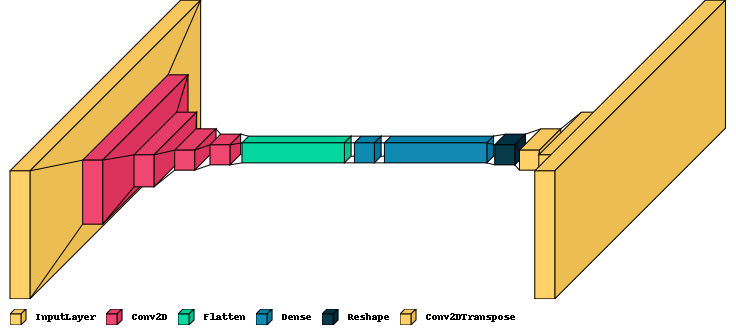

In [14]:
import visualkeras
from PIL import ImageFont

font = ImageFont.load_default()
visualkeras.layered_view(autoencoder,legend=True, font=font)

## Data Loading

In [10]:
from sklearn.model_selection import train_test_split

# Access your file using the path
data = np.load('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/Train_Test_Scipy.npy')
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=46, shuffle=True)
print ('size-data='+str (data.shape), 'size-train='+str (train_data.shape),'size-test='+str (test_data.shape) )

size-data=(2329, 128, 32, 1) size-train=(1863, 128, 32, 1) size-test=(466, 128, 32, 1)


## Training

In [9]:
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate= 0.001,
    decay_steps=1000,
    decay_rate=0.8)

### Adapting the learning rate of the optimizer using an exponential decay schedule

optimizer = Adam(learning_rate=lr_schedule)

es = EarlyStopping( monitor='val_loss', mode='min', verbose=1, patience=30), CSVLogger('Pretrain_log.csv')

autoencoder.compile(optimizer=optimizer, loss='mse')
autoencoder.fit(train_data, train_data, batch_size=32, epochs=1000 ,validation_data=(test_data, test_data), callbacks=[es])

2024-01-30 17:55:14.942303: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 48.83MiB (rounded to 51200000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-30 17:55:14.942343: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-30 17:55:14.942353: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 34, Chunks in use: 34. 8.5KiB allocated for chunks. 8.5KiB in use in bin. 920B client-requested in use in bin.
2024-01-30 17:55:14.942360: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 0. 768B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-01-30 17:55:14.942368: I external

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f2d1cc01100 of size 256 next 22
2024-01-30 17:55:14.942596: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f2d1cc01200 of size 256 next 20
2024-01-30 17:55:14.942601: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f2d1cc01300 of size 256 next 8
2024-01-30 17:55:14.942605: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f2d1cc01400 of size 1280 next 9
2024-01-30 17:55:14.942610: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f2d1cc01900 of size 256 next 26
2024-01-30 17:55:14.942614: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f2d1cc01a00 of size 4096 next 28
2024-01-30 17:55:14.942619: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f2d1cc02a00 of size 256 next 30
2024-01-30 17:55:14.942623: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 7f2d1cc02b00 of size 256 next 32
20

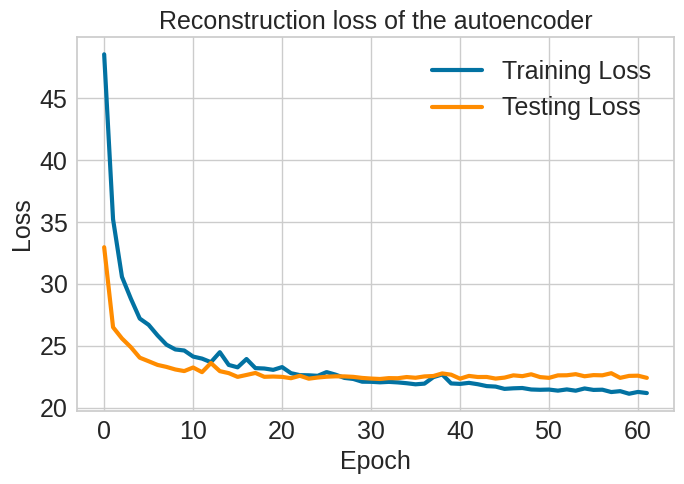

In [20]:
import pandas as pd
df = pd.read_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/notebook/Pretrain_log.csv')
fig= plt.figure(figsize=(7, 5))
plt.plot(df['epoch'],df['loss'], color='b',label='Training Loss', linewidth=3.0)
plt.plot(df['epoch'],df['val_loss'], color='darkorange',label='Testing Loss', linewidth=3.0)

plt.ylabel('Loss', fontsize= 18)
plt.xlabel('Epoch', fontsize= 18)
plt.title('Reconstruction loss of the autoencoder', fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)

plt.legend(loc= 1, frameon= False, fontsize= 18)
plt.tight_layout()
plt.show ()

In [ ]:
### Save the model
from tensorflow.keras.models import save_model
autoencoder.save ('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/Models/autoencoder-model2')

### Kmeans clustering based on extracted features from the autoencoder

In [4]:
from tensorflow.keras.models import load_model

autoencoder = load_model('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/Models/autoencoder-model2')
autoencoder_input = autoencoder.input
encoder_output = autoencoder.get_layer('dense_1').output
encoder = Model(inputs=autoencoder_input, outputs=encoder_output)

2024-01-27 17:01:40.909631: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


73/73 [==============================] - 0s 2ms/step


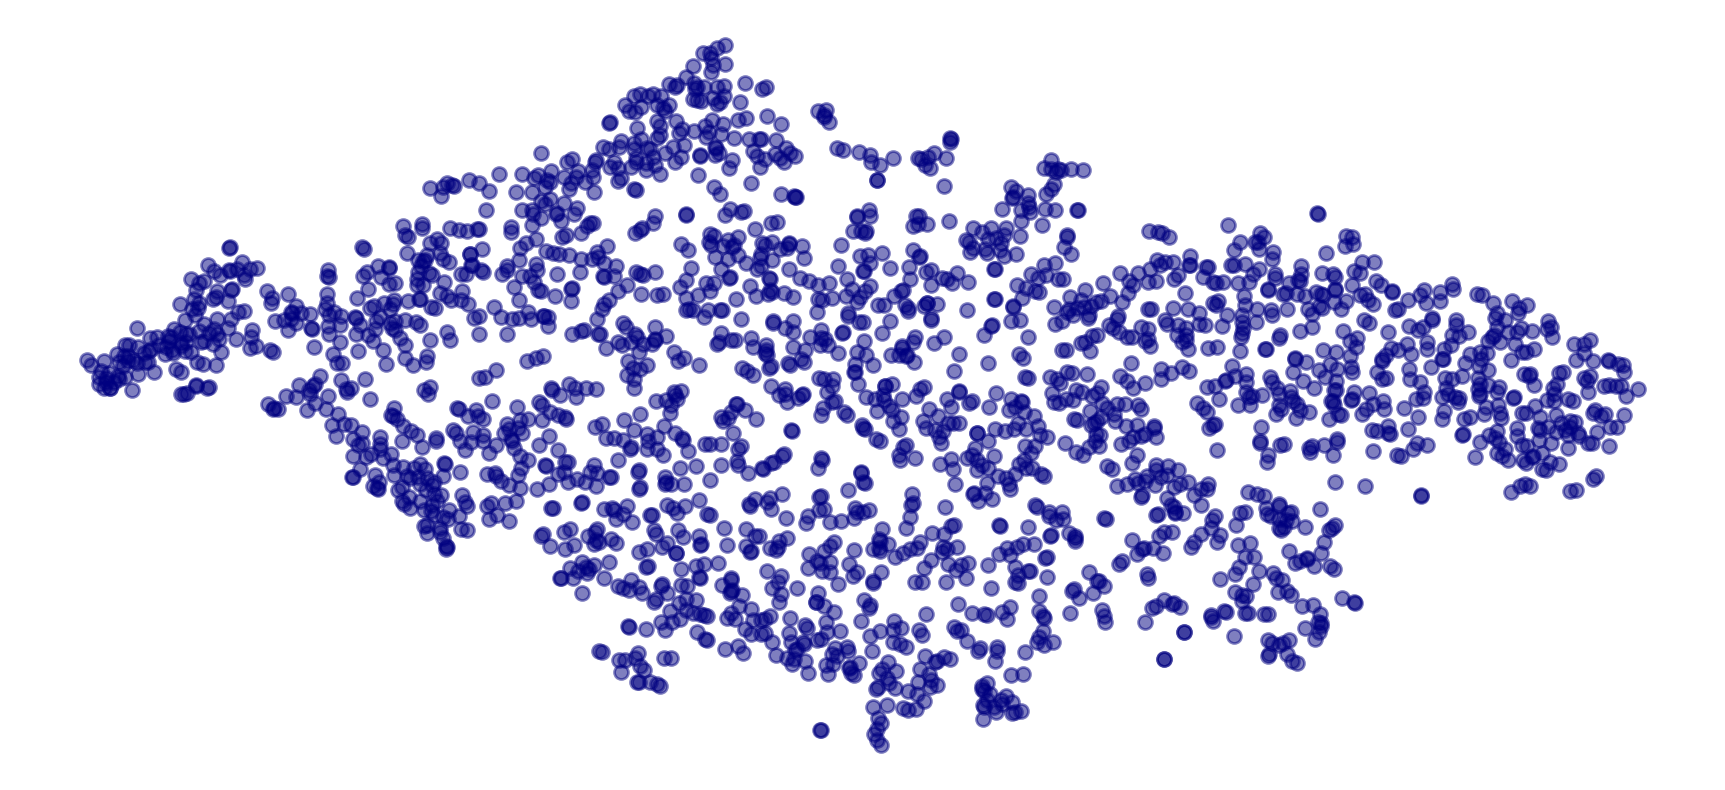

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [5]:
kmeans = KMeans(n_clusters=1, random_state=46, n_init=20).fit(encoder.predict(data))
y = kmeans.predict(encoder.predict(data))

def plotter(S, y):
    '''
    function to visualize the outputs of t-SNE
    '''

    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    plt.scatter(S[y == 0, 0], S[y == 0, 1],color='navy', alpha=.5, lw=lw, s=100)
    ax.axis('off')
    ax.axis('tight')
    plt.show()

    return f, ax

enc = encoder.predict(data)
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
plotter(redu, y)

Determining optimal number of clusters

73/73 [==============================] - 0s 2ms/step


73/73 [==============================] - 0s 2ms/step


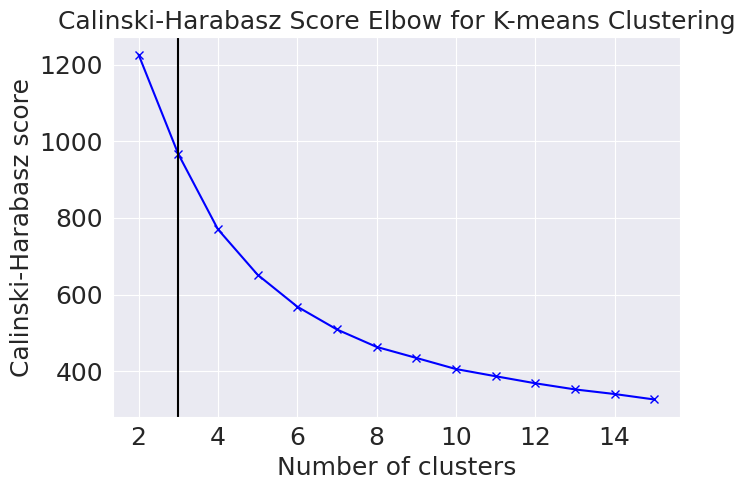

In [6]:
from sklearn.metrics import calinski_harabasz_score
cal = []
K = range(2,16)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20).fit(encoder.predict(data))
    labelskm = kmeans.predict(encoder.predict(data))
    cal.append(calinski_harabasz_score(encoder.predict(data), labelskm))
fig= plt.figure(figsize=(7, 5))
plt.plot(K, cal, 'bx-')
plt.xlabel('Number of clusters',fontsize= 18)
plt.ylabel('Calinski-Harabasz score',fontsize= 18)
plt.title('Calinski-Harabasz Score Elbow for K-means Clustering',fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)
plt.axvline(x = 3, color = 'black')
plt.tight_layout()
plt.show()

73/73 [==============================] - 0s 2ms/step


73/73 [==============================] - 0s 2ms/step


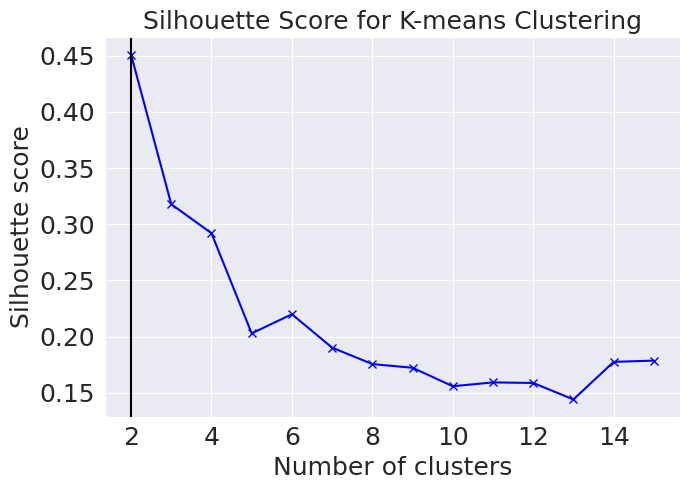

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette_scores = []
K = range(2, 16)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20).fit(encoder.predict(data))
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(encoder.predict(data), labels))

# Plotting the silhouette scores
fig = plt.figure(figsize=(7, 5))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters', fontsize=18)
plt.ylabel('Silhouette score', fontsize=18)
plt.title('Silhouette Score for K-means Clustering', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axvline(x=silhouette_scores.index(max(silhouette_scores)) + 2, color='black')  # +2 because range starts at 2
plt.tight_layout()
plt.show()

73/73 [==============================] - 0s 2ms/step


73/73 [==============================] - 0s 2ms/step
Silhouette scores for different numbers of clusters:
Clusters: 2, Silhouette Score: 0.4509
Clusters: 3, Silhouette Score: 0.3178
Clusters: 4, Silhouette Score: 0.2920
Clusters: 5, Silhouette Score: 0.2029


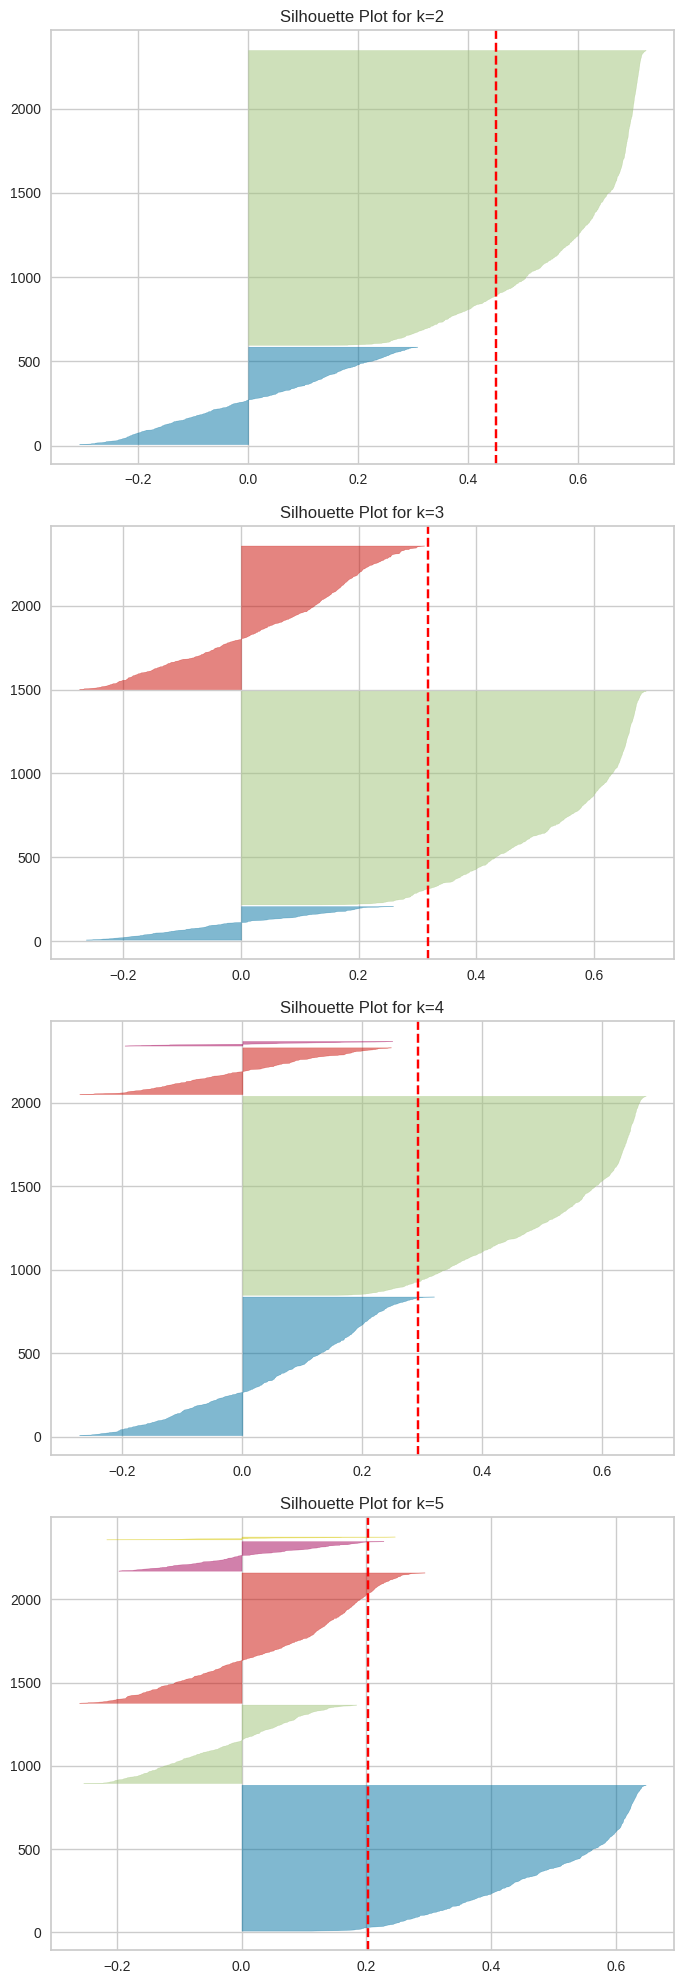

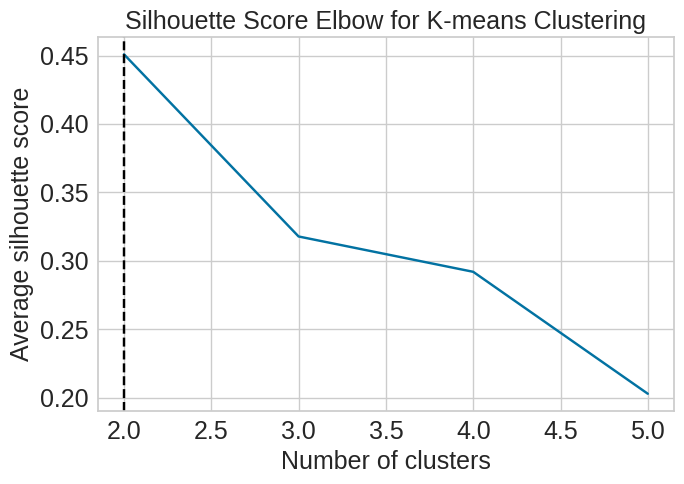

In [8]:
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt

# Calculate the encoded features only once
encoded_data = encoder.predict(data)

# Generate encoded data
encoded_data = encoder.predict(data)

# Range of clusters to evaluate
K = range(2, 6)
silhouette_avg_scores = []  # To store the average silhouette scores

print("Silhouette scores for different numbers of clusters:")
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20).fit(encoded_data)
    labels = kmeans.labels_
    score = silhouette_score(encoded_data, labels)
    silhouette_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

# Create subplots for silhouette visualizers
fig, axes = plt.subplots(len(K), 1, figsize=(7, 5*len(K)))

# Loop over the range of cluster numbers to fit KMeans and calculate silhouette scores
for idx, k in enumerate(K):
    # Fit KMeans and predict the cluster labels
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    cluster_labels = kmeans.fit_predict(encoded_data)
    
    # Calculate the average silhouette score and append to the list
    silhouette_avg = silhouette_score(encoded_data, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    
    # Initialize the SilhouetteVisualizer with the KMeans model
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[idx])
    visualizer.fit(encoded_data)
    axes[idx].set_title(f'Silhouette Plot for k={k}', fontsize=12)

# Adjust the layout
plt.tight_layout()

# Plot the average silhouette scores
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(K, silhouette_avg_scores, 'bx-')
ax.set_xlabel('Number of clusters', fontsize=18)
ax.set_ylabel('Average silhouette score', fontsize=18)
ax.set_title('Silhouette Score Elbow for K-means Clustering', fontsize=18)
ax.axvline(x=K[silhouette_avg_scores.index(max(silhouette_avg_scores))], color='black', linestyle='--')
ax.tick_params(axis='x', labelsize=18)  # Corrected line for setting x-tick label sizes
ax.tick_params(axis='y', labelsize=18)  # Corrected line for setting y-tick label sizes
plt.tight_layout()
plt.show()

### T-sne visualizations of seismic event clusters in feature domain after pretraining using K-Means

27/73 [==========>...................] - ETA: 0s

73/73 [==============================] - 0s 2ms/step
Cluster counts: {0: 200, 1: 1273, 2: 856}


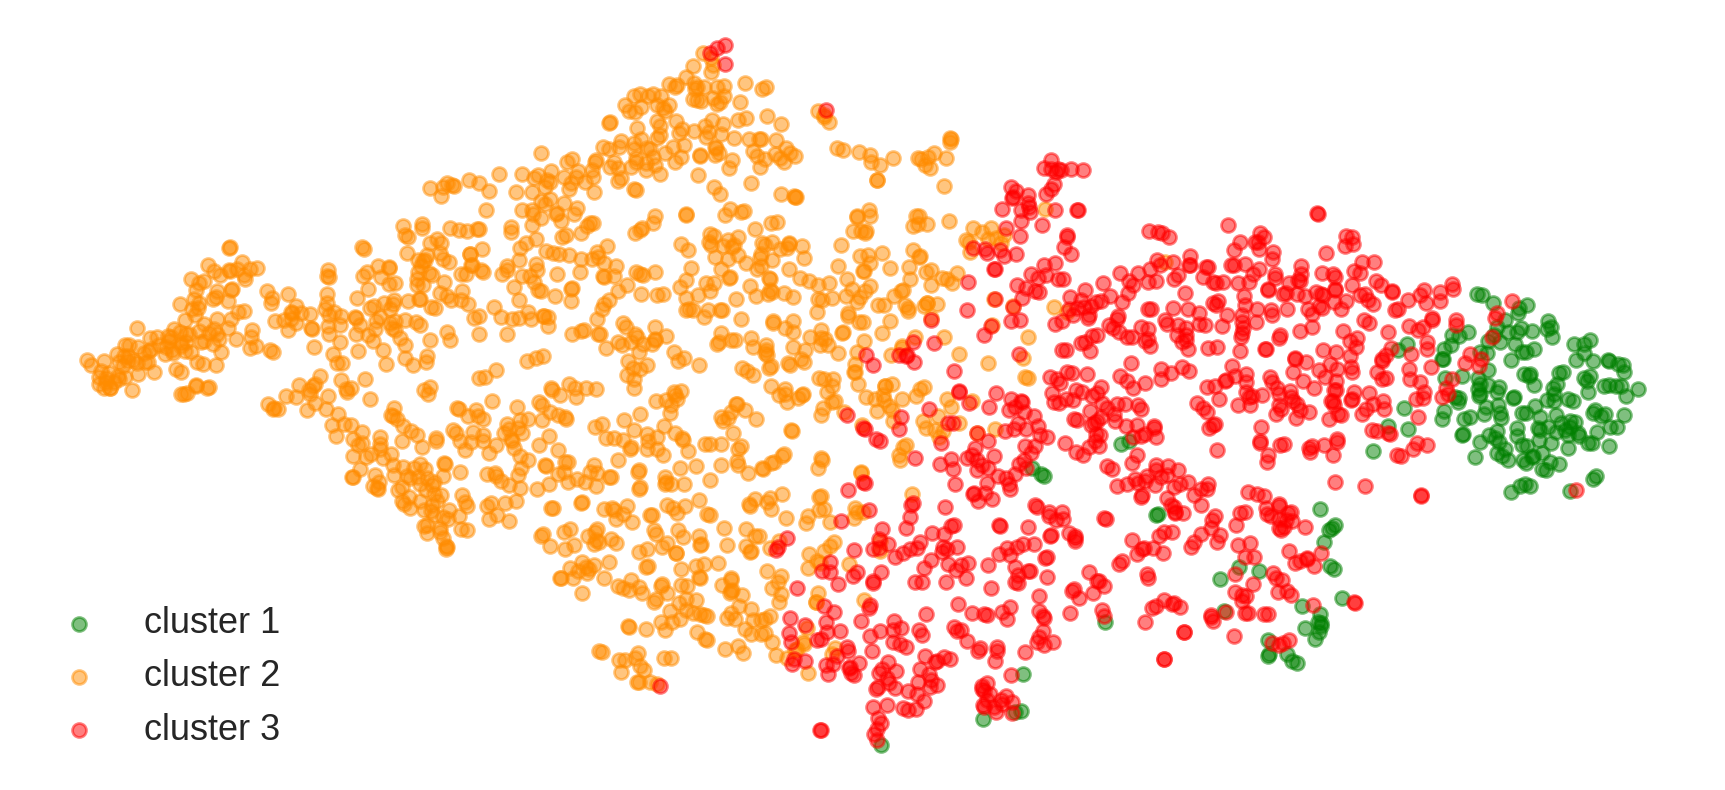

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [9]:
kmeans = KMeans(n_clusters=3, random_state=46, n_init=20).fit(encoder.predict(data))
y = kmeans.predict(encoder.predict(data))

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['green','darkorange','red']

    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
      plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight')
    plt.show()

    return f, ax

enc = encoder.predict(data)
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = ['cluster 1', 'cluster 2', 'cluster 3']

# Print the cluster counts
(unique, counts) = np.unique(y, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("Cluster counts:", cluster_counts)

plotter(redu, y, target_names)

In [8]:
### Save the labels
np.savetxt('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft_Pretrain.txt', y, fmt='%i', delimiter=',')


In [9]:
# Path to the file
file_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft_Pretrain.txt'

# Initialize a dictionary to count cluster occurrences
cluster_counts = {}

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        cluster = line.strip()
        if cluster in cluster_counts:
            cluster_counts[cluster] += 1
        else:
            cluster_counts[cluster] = 1

# Print the counts for each cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} occurrences")


Cluster 1: 1273 occurrences
Cluster 2: 856 occurrences
Cluster 0: 200 occurrences


### Loading the Pre-trained Model

In [10]:
from tensorflow.keras.models import load_model
autoencoder = load_model("/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/Models/autoencoder-model2")

In [11]:
import keras.backend as K
get_all_layer_outputs = K.function([autoencoder.layers[0].input],
                                  [l.output for l in autoencoder.layers[1:]])

layer_output = get_all_layer_outputs([data]) # return the same thing

In [12]:
n_clusters=3

### Integrating clustering layer into autoencoder bottelneck

In [13]:
from numpy.random import seed
sd=46
seed(sd)
import tensorflow
import tensorflow as tf
tensorflow.random.set_seed(sd)

initializer = tf.keras.initializers.GlorotUniform(seed=sd)

#### clustering layers
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer= initializer , name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


print('...Finetuning...')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(autoencoder.layers[6].output)
model = Model(inputs=autoencoder.layers[0].output, outputs=clustering_layer)
model.compile(loss='kld', loss_weights=0.1,  optimizer=SGD(learning_rate=0.01,  momentum=0.9))


...Finetuning...


In [14]:
### Initializing the weights using Kmean and assigning them to the model

kmeans = KMeans(n_clusters=n_clusters,  random_state=46, n_init=20)
y_pred = kmeans.fit_predict(layer_output[5])
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])


## Finetuning Pre-Trained Model Parameters

In [15]:
## parameters for the finetuning
x = data
batch_size=32
tol = 0.0001 # tolerance threshold to stop training
loss = 0
index = 0
maxiter = 100000
update_interval = 500
index_array = np.arange(x.shape[0])

###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(data, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        y_pred = q.argmax(1) # evaluate the clustering performance

        loss = np.round(loss, 5)
        print('Iter %d: ' % (ite), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)

        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            break

        IN = layer_output[5]

    idx = index_array[index * batch_size: min((index+1) * batch_size, data.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

Iter 0:   ; loss= 0


2024-01-27 17:05:26.013225: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f67e0b49c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-27 17:05:26.013256: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-01-27 17:05:26.013262: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
I0000 00:00:1706349926.114602 2952019 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iter 500:   ; loss= 0.00473
Iter 1000:   ; loss= 0.00479
Iter 1500:   ; loss= 0.00549
Iter 2000:   ; loss= 0.00921
Iter 2500:   ; loss= 0.00472
Iter 3000:   ; loss= 0.00586
Iter 3500:   ; loss= 0.00427
Iter 4000:   ; loss= 0.01082
Iter 4500:   ; loss= 0.00371
Iter 5000:   ; loss= 0.00701
Iter 5500:   ; loss= 0.00833
Iter 6000:   ; loss= 0.00449
Iter 6500:   ; loss= 0.00858
Iter 7000:   ; loss= 0.00721
Iter 7500:   ; loss= 0.012
Iter 8000:   ; loss= 0.00478
Iter 8500:   ; loss= 0.00804
Iter 9000:   ; loss= 0.01666
Iter 9500:   ; loss= 0.00602
Iter 10000:   ; loss= 0.00418
Iter 10500:   ; loss= 0.01335
Iter 11000:   ; loss= 0.00963
Iter 11500:   ; loss= 0.00804
Iter 12000:   ; loss= 0.00799
Iter 12500:   ; loss= 0.00456
Iter 13000:   ; loss= 0.00605
Iter 13500:   ; loss= 0.00519
Iter 14000:   ; loss= 0.00591
Iter 14500:   ; loss= 0.00433
Iter 15000:   ; loss= 0.01088
Iter 15500:   ; loss= 0.00685
Iter 16000:   ; loss= 0.00619
Iter 16500:   ; loss= 0.0062
Iter 17000:   ; loss= 0.01172
Ite

In [16]:
import keras.backend as K
get_all_layer_outputs = K.function([autoencoder.layers[0].input],
                                  [l.output for l in autoencoder.layers[1:]])

layer_output = get_all_layer_outputs([x]) # return the same thing

In [17]:
autoencoder.save('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/Models/autoencoder-model2_finetuned')

INFO:tensorflow:Assets written to: /run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/Models/autoencoder-model2_finetuned/assets


INFO:tensorflow:Assets written to: /run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/Models/autoencoder-model2_finetuned/assets


### T-sne visualizations of seismic event clusters in feature domain after finetuning

Cluster counts: {0: 642, 1: 916, 2: 771}


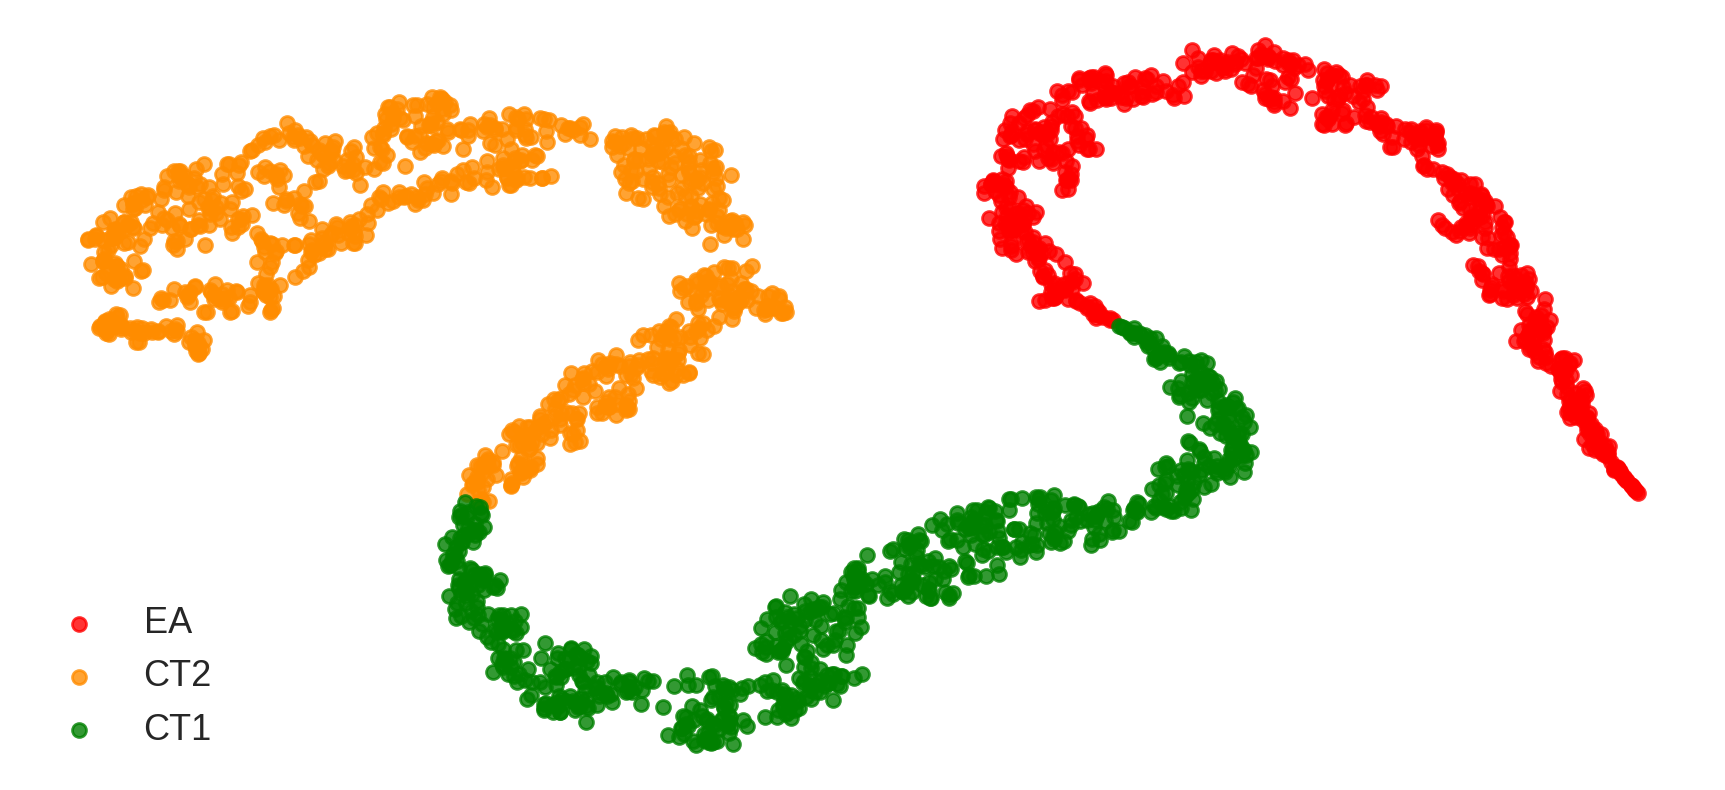

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [18]:
y=y_pred

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['red','darkorange','green']

    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, range(len(target_names)), target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.8, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight')
    plt.show()

    return f, ax

enc = layer_output[5]
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = ['EA', 'CT2', 'CT1']

# Print the cluster counts
(unique, counts) = np.unique(y, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print("Cluster counts:", cluster_counts)

plotter(redu, y, target_names)

### Rewriting Cluser Result for Temporal Analysis

In [27]:
### Save the labels
np.savetxt('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft.txt', y, fmt='%i', delimiter=',')


In [26]:
# Path to the file
file_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft.txt'

# Initialize a dictionary to count cluster occurrences
cluster_counts = {}

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        cluster = line.strip()
        if cluster in cluster_counts:
            cluster_counts[cluster] += 1
        else:
            cluster_counts[cluster] = 1

# Print the counts for each cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} occurrences")


Cluster 2: 771 occurrences
Cluster 0: 642 occurrences
Cluster 1: 916 occurrences


In [28]:
# Change the order of the cluster numbers (just for a nice representation)

with open('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft.txt', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('2', 'x')
filedata = filedata.replace('0', '2')
filedata = filedata.replace('1', '0')
filedata = filedata.replace('x', '1')

# Re-write the output
with open('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft_Rewritten.txt', 'w') as file:
  file.write(filedata)

In [29]:
# Path to the file
file_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft_Rewritten.txt'

# Initialize a dictionary to count cluster occurrences
cluster_counts = {}

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        cluster = line.strip()
        if cluster in cluster_counts:
            cluster_counts[cluster] += 1
        else:
            cluster_counts[cluster] = 1

# Print the counts for each cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} occurrences")


Cluster 1: 771 occurrences
Cluster 2: 642 occurrences
Cluster 0: 916 occurrences


## Adding new unforseen data

### Validation Data Loading

In [43]:
new_data = np.load('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/valid_Scipy.npy')
print ('size-data='+str (new_data.shape))

size-data=(211, 128, 32, 1)


In [45]:
from tensorflow.keras.models import load_model

# Load the finetuned model
autoencoder = load_model('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/Models/autoencoder-model_finetuned')

7/7 [==============================] - 0s 4ms/step


7/7 [==============================] - 0s 3ms/step


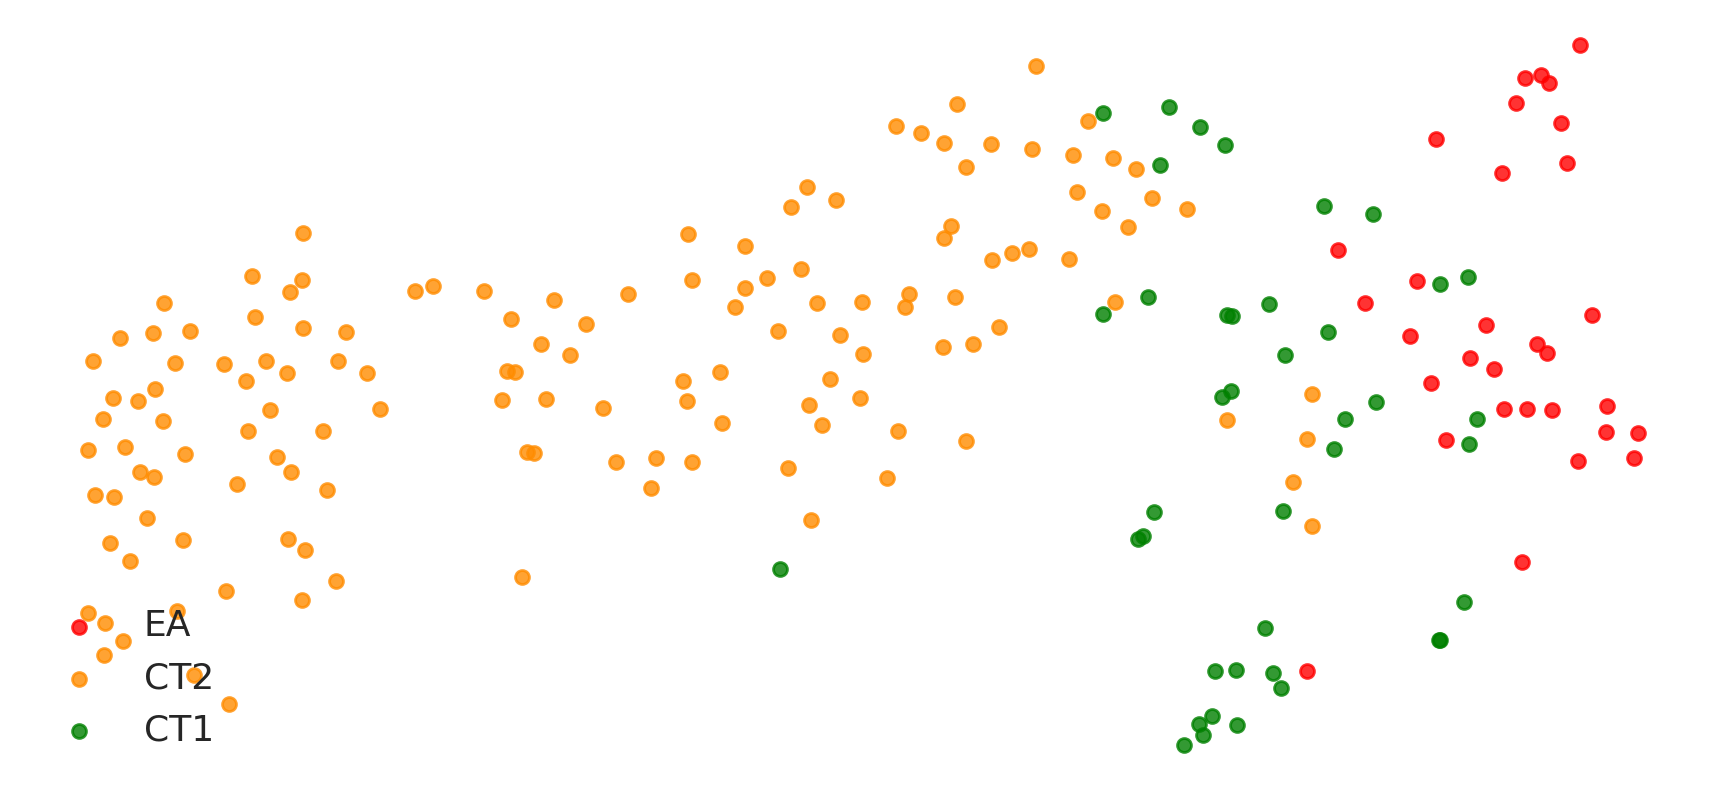

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [46]:
from joblib import load
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Predict encoded features for new_data
encoded_features = encoder.predict(new_data)

# Apply t-SNE
tsne_output = TSNE(random_state=123).fit_transform(encoded_features)

# Predict cluster assignments for new_data using the full model
cluster_assignments = model.predict(new_data)
y = np.argmax(cluster_assignments, axis=1)  # convert soft assignments to hard

# Define the plotter function
def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['red', 'darkorange', 'green']

    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, range(len(target_names)), target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.8, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight')
    plt.show()
    f.savefig ('Tsne-km-n3-ft.png', dpi=100, bbox_inches="tight")

    return f, ax

# Target names for clusters
target_names = ['EA', 'CT2', 'CT1']  # Adjust as per your actual cluster names

# Visualize
plotter(tsne_output, y, target_names)


In [47]:
### Save the labels
np.savetxt('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Valid-n3-ft.txt', y, fmt='%i', delimiter=',')

In [ ]:
# Path to the file
file_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Valid-n3-ft.txt'

# Initialize a dictionary to count cluster occurrences
cluster_counts = {}

# Read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        cluster = line.strip()
        if cluster in cluster_counts:
            cluster_counts[cluster] += 1
        else:
            cluster_counts[cluster] = 1

# Print the counts for each cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} occurrences")


Cluster 1: 211 occurrences


In [48]:
# Change the order of the cluster numbers (just for a nice representation)

with open('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Valid-n3-ft.txt', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('2', 'x')
filedata = filedata.replace('0', '2')
filedata = filedata.replace('1', '0')
filedata = filedata.replace('x', '1')

# Re-write the output
with open('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Valid-n3-ft_Rewritten.txt', 'w') as file:
  file.write(filedata)

# Temporal Visualization of Cluster Distribution

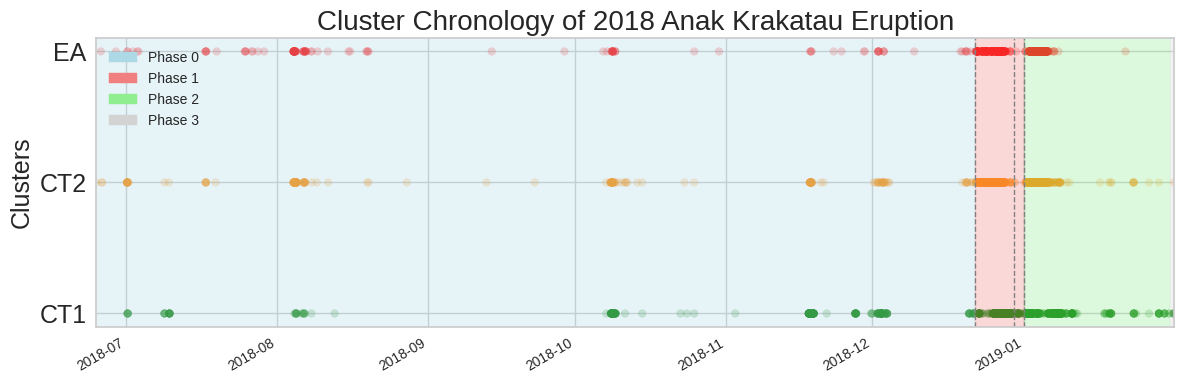

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load the numpy array containing the datetime index
datetime_index_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/train_test_datetime.npy'
y_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft_Rewritten.txt'
filtered_vona_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/filtered_VONA.csv'  # Update this path to your local file

datetime_index = np.load(datetime_index_path, allow_pickle=True)
datetime_index = pd.to_datetime(datetime_index).tz_localize(None)  # Remove timezone information to make it tz-naive

# Specific dates for axvline and phases
specific_dates = [
    '2018-12-22 00:00:00',
    '2018-12-30 00:00:00',
    '2019-01-01 00:00:00',
    '2019-05-22 00:00:00'
]

phase_intervals = [
    ('2018-06-18 00:00:00', '2018-12-22 00:00:00'),  # Phase 0
    ('2018-12-22 00:00:00', '2019-01-01 00:00:00'),  # Phase 1
    ('2019-01-01 00:00:00', '2019-01-31 00:00:00'),  # Phase 2
    ('2019-01-31 00:00:00', '2019-05-22 00:00:00')   # Phase 3 (I added this)
]

# Define the colors for each phase
phase_colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightgrey']  # lightcoral is a light red color

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Set up the colormap for three clusters
colors = ['green','darkorange','red']
cmap = LinearSegmentedColormap.from_list('my_list', colors, N=3)

# Create scatter plot
scatter = ax.scatter(datetime_index, y, c=y, cmap=cmap, s=30, alpha=0.2)

# Set y-ticks and labels for three clusters
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['CT1', 'CT2', 'EA'], fontsize=18)

plt.ylabel('Clusters', fontsize=18)
ax.xaxis_date()  # Set x-axis to use date format
fig.autofmt_xdate()  # Auto-format the date labels

# Set x-axis limits
plt.xlim(datetime_index[0], datetime_index[-1])

# Add vertical lines at specific dates
for date in specific_dates:
    ax.axvline(pd.to_datetime(date), color='grey', linestyle='--', linewidth=1)

# Add background color and labels for each phase
for i, (interval, color) in enumerate(zip(phase_intervals, phase_colors)):
    start_date, end_date = pd.to_datetime(interval[0]), pd.to_datetime(interval[1])
    ax.axvspan(start_date, end_date, color=color, alpha=0.3, label=f'Phase {i}')

# Create a legend for the phases
handles, labels = ax.get_legend_handles_labels()
# Create custom legend for phases
from matplotlib.patches import Patch
custom_handles = [Patch(facecolor=pc, edgecolor=pc) for pc in phase_colors]
plt.legend(custom_handles, [f'Phase {i}' for i in range(len(phase_intervals))], loc='upper left')

# Set the title
plt.title('Cluster Chronology of 2018 Anak Krakatau Eruption', fontsize=20)

plt.tight_layout()
plt.show()


## Phase 0

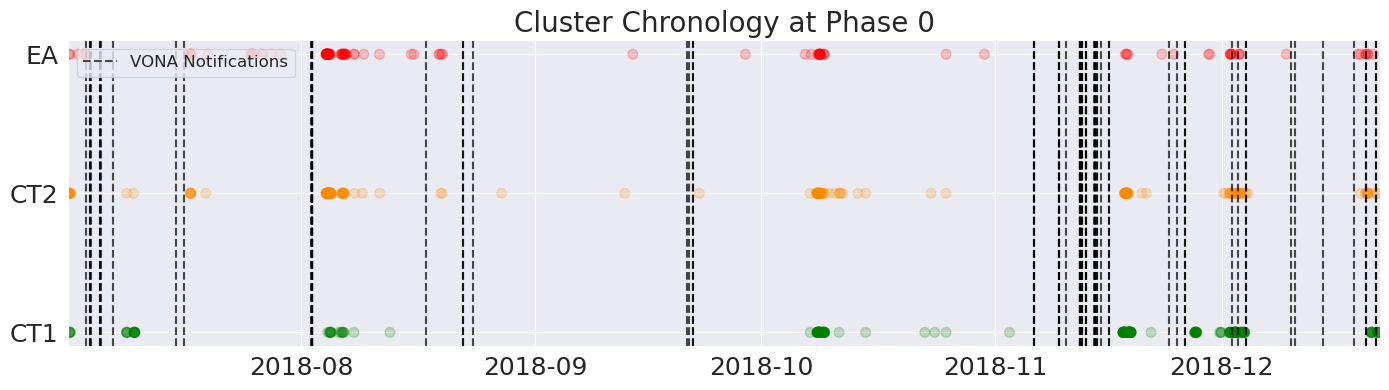

In [82]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np

# Load the necessary data
datetime_index_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/train_test_datetime.npy'
y_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft_Rewritten.txt'
filtered_vona_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/filtered_VONA.csv'  # Update this path to your local file

datetime_index = np.load(datetime_index_path, allow_pickle=True)
datetime_index = pd.to_datetime(datetime_index).tz_localize(None)  # Remove timezone information to make it tz-naive
y = np.loadtxt(y_path)
filtered_vona_df = pd.read_csv(filtered_vona_path)

# Explicitly convert 'Issued' column to datetime
filtered_vona_df['Issued'] = pd.to_datetime(filtered_vona_df['Issued'])

# Determine the date range from the data itself
date_range = (datetime_index.min().strftime('%Y-%m-%d'), datetime_index.max().strftime('%Y-%m-%d'))

# Set up the colormap
colors = ['green', 'darkorange', 'red']
cmap = LinearSegmentedColormap.from_list('my_list', colors)

# Define your date range
date_range = ('2018-07-01', '2018-12-22')

# Create a figure
fig, ax = plt.subplots(figsize=(14, 4))

# Convert Pandas Timestamp to NumPy datetime64[ns]
dates_filtered_np = datetime_index.to_numpy()

# Filter the data for the current date range
mask = (dates_filtered_np >= pd.to_datetime(date_range[0])) & (dates_filtered_np <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=50, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2', 'EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")

    # Adding a legend for VONA Notifications
    ax.legend(loc='upper left', fontsize='large')

    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot
ax.set_title("Cluster Chronology at Phase 0", fontsize=20)

plt.tight_layout()
plt.show()


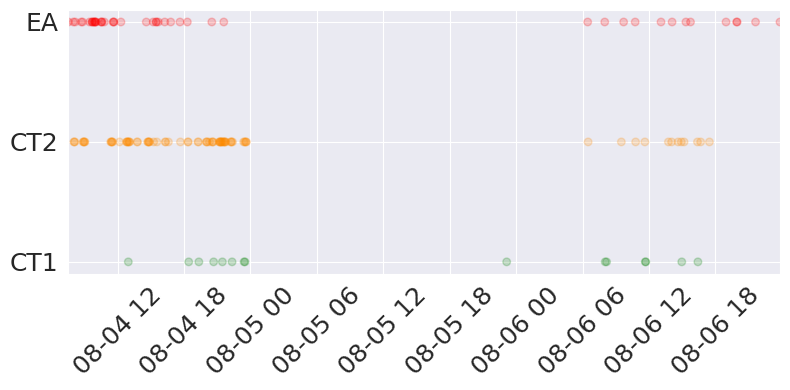

In [73]:
import matplotlib.dates as mdates


# Define your date range
date_range = ('2018-08-03', '2018-08-07')

# Create a figure
fig, ax = plt.subplots(figsize=(8, 4))

# Filter the data for the current date range
mask = (datetime_index >= pd.to_datetime(date_range[0])) & (datetime_index <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=30, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2', 'EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates

    # Decrease the x-ticks frequency
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H'))
    plt.xticks(rotation=45)

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")


    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot

plt.tight_layout()
plt.show()

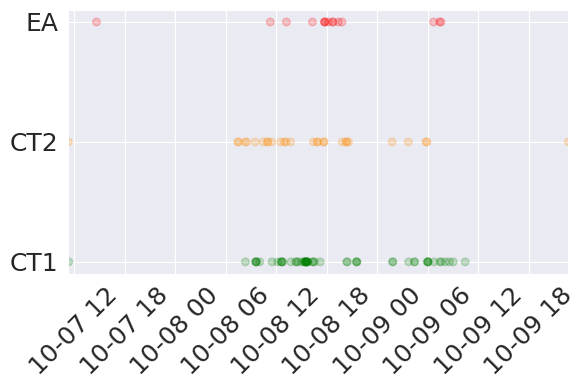

In [78]:
import matplotlib.dates as mdates


# Define your date range
date_range = ('2018-10-07 00:00:00', '2018-10-10 00:00:00')

# Create a figure
fig, ax = plt.subplots(figsize=(6, 4))

# Filter the data for the current date range
mask = (datetime_index >= pd.to_datetime(date_range[0])) & (datetime_index <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=30, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2', 'EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates

    # Decrease the x-ticks frequency
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H'))
    plt.xticks(rotation=45)

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")


    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot

plt.tight_layout()
plt.show()

## Phase 1

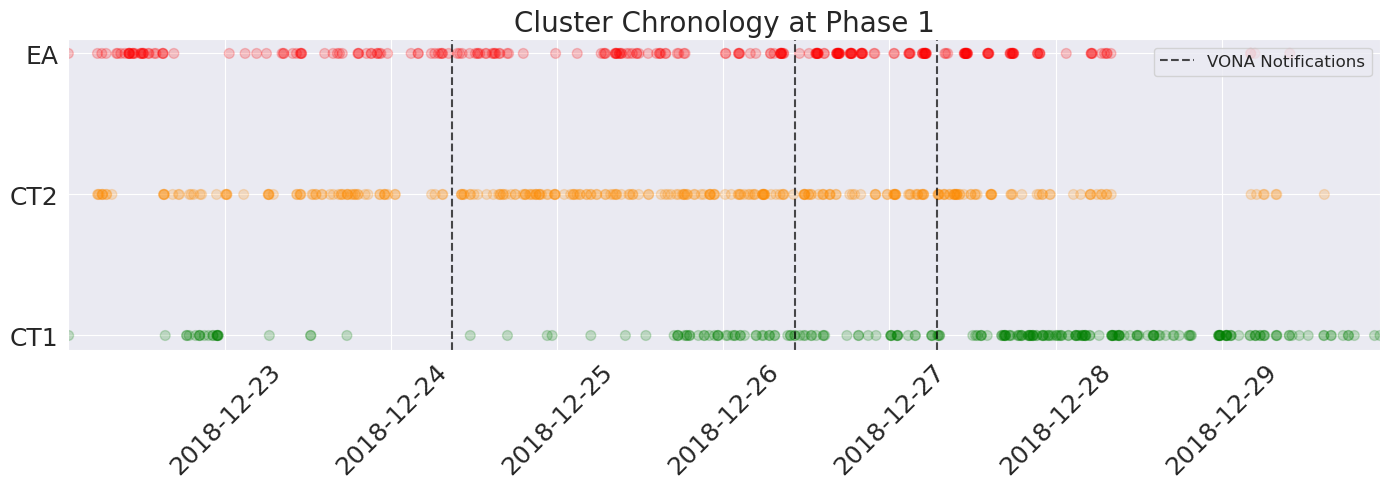

In [83]:
date_range = ('2018-12-22', '2018-12-30')

# Set up the colormap
colors = ['green','darkorange','red']
cmap = LinearSegmentedColormap.from_list('my_list', colors)

# Create a figure
fig, ax = plt.subplots(figsize=(14, 5))

# Filter the data for the current date range
mask = (datetime_index >= pd.to_datetime(date_range[0])) & (datetime_index <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=50, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2', 'EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates
    plt.xticks(rotation=45)  # Give inclination to the x-axis labels

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")

    # Adding a legend for VONA Notifications
    ax.legend(loc='upper right', fontsize='large')

    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot
ax.set_title("Cluster Chronology at Phase 1", fontsize=20)

plt.tight_layout()
plt.show()

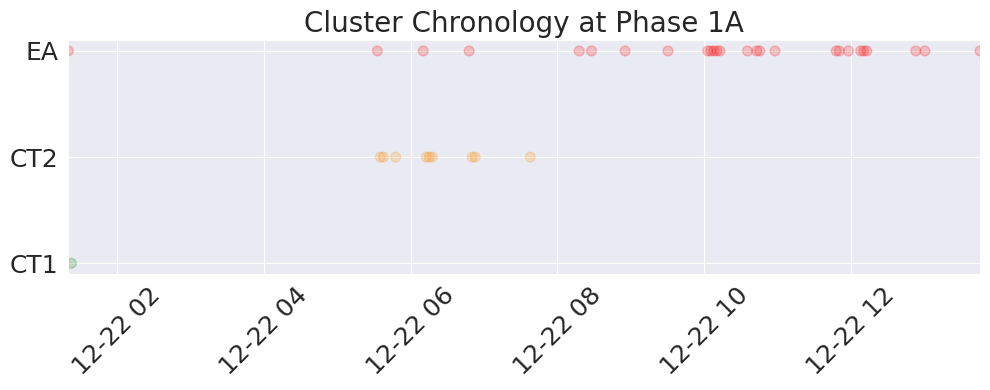

In [84]:
date_range = ('2018-12-22 00:00:00', '2018-12-22 13:50:00')

# Create a figure
fig, ax = plt.subplots(figsize=(10, 4))

# Filter the data for the current date range
mask = (datetime_index >= pd.to_datetime(date_range[0])) & (datetime_index <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=50, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2','EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates
    plt.xticks(rotation=45)  # Give inclination to the x-axis labels

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")

    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot
ax.set_title("Cluster Chronology at Phase 1A", fontsize=20)

plt.tight_layout()
plt.show()

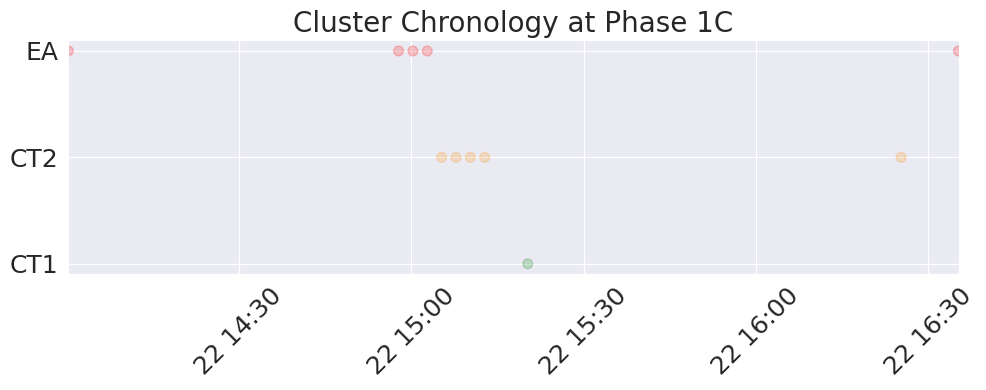

In [85]:
date_range = ('2018-12-22 14:00:00', '2018-12-22 16:55:00')

# Create a figure
fig, ax = plt.subplots(figsize=(10, 4))

# Filter the data for the current date range
mask = (datetime_index >= pd.to_datetime(date_range[0])) & (datetime_index <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=50, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2','EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates
    plt.xticks(rotation=45)  # Give inclination to the x-axis labels

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")

    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot
ax.set_title("Cluster Chronology at Phase 1C", fontsize=20)

plt.tight_layout()
plt.show()

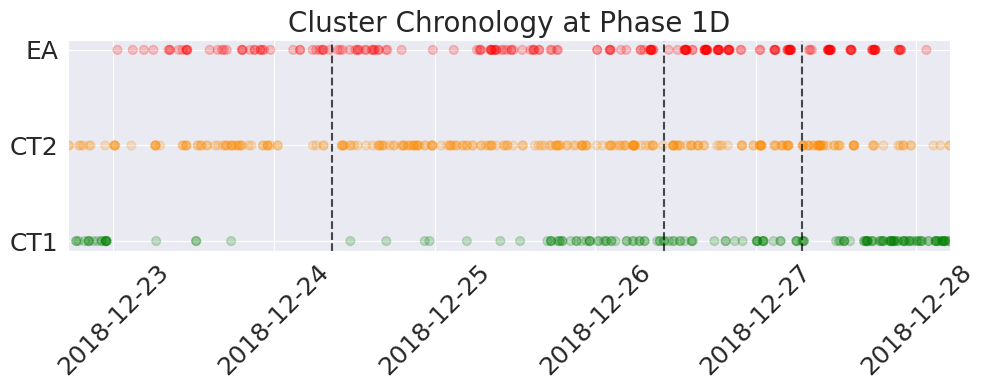

In [87]:
date_range = ('2018-12-22 16:55:00', '2018-12-28 05:05:00')

# Create a figure
fig, ax = plt.subplots(figsize=(10, 4))

# Filter the data for the current date range
mask = (datetime_index >= pd.to_datetime(date_range[0])) & (datetime_index <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=40, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2','EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates
    plt.xticks(rotation=45)  # Give inclination to the x-axis labels

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")

    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot
ax.set_title("Cluster Chronology at Phase 1D", fontsize=20)

plt.tight_layout()
plt.show()

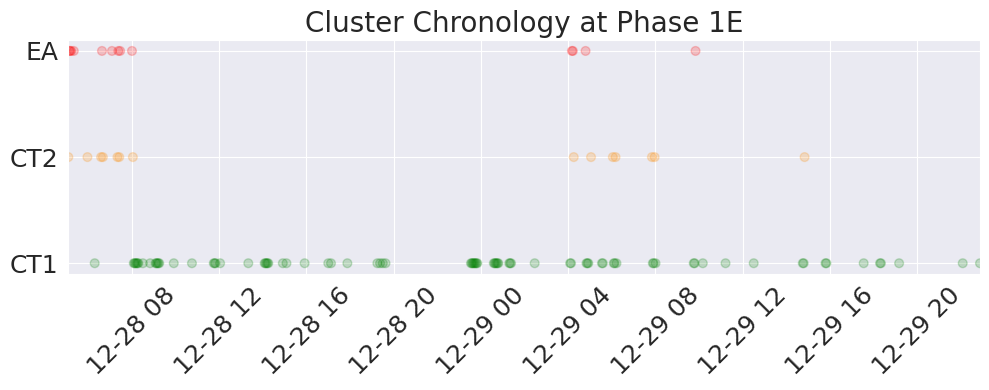

In [88]:
# Define your date range
date_range = ('2018-12-28 05:05:00', '2018-12-30 00:00:00')

# Create a figure
fig, ax = plt.subplots(figsize=(10, 4))

# Filter the data for the current date range
mask = (datetime_index >= pd.to_datetime(date_range[0])) & (datetime_index <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=40, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2','EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates
    plt.xticks(rotation=45)  # Give inclination to the x-axis labels

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")

    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot
ax.set_title("Cluster Chronology at Phase 1E", fontsize=20)

plt.tight_layout()
plt.show()

## Phase 2

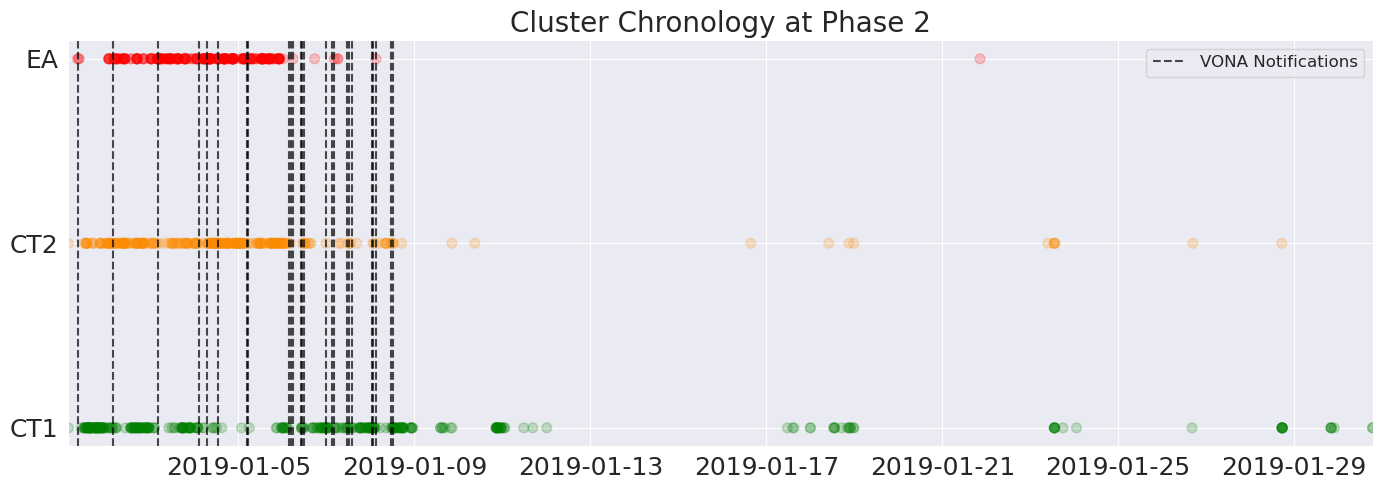

In [89]:
date_range = ('2019-01-01 00:00:00', '2019-01-31 00:00:00')

# Create a figure
fig, ax = plt.subplots(figsize=(14, 5))

# Filter the data for the current date range
mask = (datetime_index >= pd.to_datetime(date_range[0])) & (datetime_index <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=50, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2', 'EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")

    # Adding a legend for VONA Notifications
    ax.legend(loc='upper right', fontsize='large')

    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot
ax.set_title("Cluster Chronology at Phase 2", fontsize=20)

plt.tight_layout()
plt.show()

## Phase 3 (Validation Data)

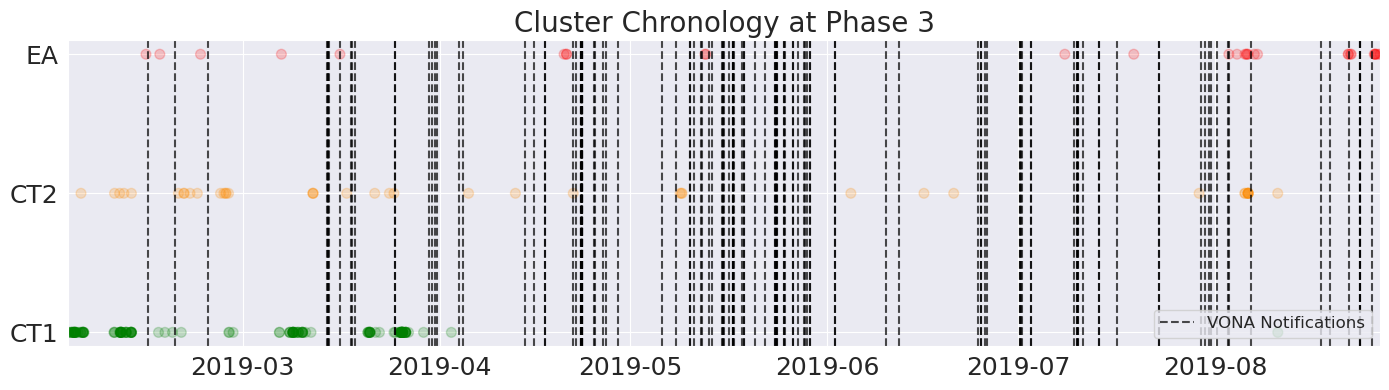

In [90]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import numpy as np

# Load the necessary data
datetime_index_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/valid_datetime.npy'
y_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Valid-n3-ft_Rewritten.txt'
filtered_vona_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/filtered_VONA.csv'  # Update this path to your local file

datetime_index = np.load(datetime_index_path, allow_pickle=True)
datetime_index = pd.to_datetime(datetime_index).tz_localize(None)  # Remove timezone information to make it tz-naive
y = np.loadtxt(y_path)
filtered_vona_df = pd.read_csv(filtered_vona_path)

# Explicitly convert 'Issued' column to datetime
filtered_vona_df['Issued'] = pd.to_datetime(filtered_vona_df['Issued'])

# Determine the date range from the data itself
date_range = (datetime_index.min().strftime('%Y-%m-%d'), datetime_index.max().strftime('%Y-%m-%d'))

# Set up the colormap
colors = ['green', 'darkorange', 'red']
cmap = LinearSegmentedColormap.from_list('my_list', colors)

# Define your date range
date_range = ('2019-02-01', '2019-09-01')

# Create a figure
fig, ax = plt.subplots(figsize=(14, 4))

# Convert Pandas Timestamp to NumPy datetime64[ns]
dates_filtered_np = datetime_index.to_numpy()

# Filter the data for the current date range
mask = (dates_filtered_np >= pd.to_datetime(date_range[0])) & (dates_filtered_np <= pd.to_datetime(date_range[1]))
dates_filtered = datetime_index[mask]
y_filtered = y[mask]

# Plot the data
if not dates_filtered.empty:
    # Create scatter plot for the filtered data
    scatter = ax.scatter(dates_filtered, y_filtered, c=y_filtered, cmap=cmap, s=50, alpha=0.2)

    # Set y-ticks and labels
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['CT1', 'CT2', 'EA'], fontsize=18)

    # Formatting the x-axis
    ax.xaxis_date()  # Set x-axis to use date format
    ax.set_xlim(dates_filtered.min(), dates_filtered.max())  # Set x limits to the range of filtered dates

    # Shift 'Issued' dates backwards by 3311 seconds and plot vertical lines
    shifted_issued_dates = filtered_vona_df['Issued'] + pd.Timedelta(seconds=3311)
    for issued_date in shifted_issued_dates:
        ax.axvline(x=issued_date, color='black', linestyle='--', alpha=0.7, label='VONA Notifications' if issued_date == shifted_issued_dates.iloc[0] else "")

    # Adding a legend for VONA Notifications
    ax.legend(loc='lower right', fontsize='large')

    ax.tick_params(axis='x', labelsize=18)  # Increase x-axis label size

else:
    ax.set_xlim(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))  # Use the date range for the limits
    ax.text(0.5, 0.5, 'No data for this range', horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=18)  # Show message when no data is available

# Add a title to the plot
ax.set_title("Cluster Chronology at Phase 3", fontsize=20)

plt.tight_layout()
plt.show()


# Input-Decoded Visualization of Clusters

In [4]:
from keras.models import load_model


autoencoder = load_model("/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/Models/autoencoder-model2")
import keras.backend as K
get_all_layer_outputs = K.function([autoencoder.layers[0].input],
                                  [l.output for l in autoencoder.layers[1:]])
layer_output = get_all_layer_outputs([data]) # return the same thing
decoded_imgs = autoencoder.predict(data)

2024-01-09 02:25:11.135842: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


73/73 [==============================] - 1s 6ms/step


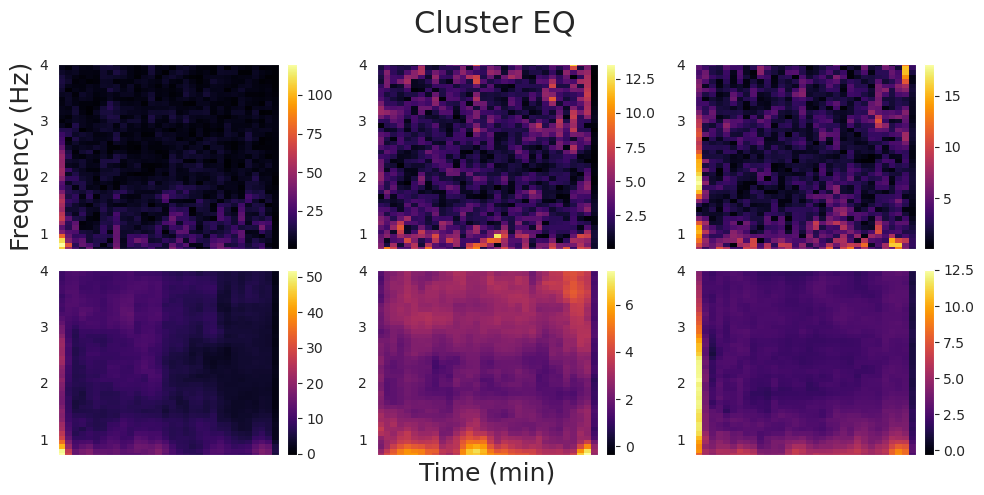

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec

sr = 20  # Replace with the actual sample rate

# Assuming n_fft is known (required to calculate frequency bins accurately)
n_fft = 254  # Replace with the actual n_fft used for STFT computation

# Calculate frequency bins
frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

# Find the index of the frequency bin closest to 0.7 Hz and 4 Hz
fmin_idx = np.abs(frequencies - 0.7).argmin()
fmax_idx = np.abs(frequencies - 4).argmin()

# Create a figure and define the subplot grid
fig = plt.figure(figsize=(10, 5))
spec = gridspec.GridSpec(2, 3)

# First Subplot
ax1 = fig.add_subplot(spec[0, 0])
librosa.display.specshow(data[50, :, :, 0], cmap='inferno', y_axis='linear', sr=sr)
plt.colorbar(pad=0.03)
plt.ylim(frequencies[fmin_idx], frequencies[fmax_idx])
plt.ylabel('Frequency (Hz)', fontsize=18)

# Second Subplot
ax2 = fig.add_subplot(spec[0, 1])
librosa.display.specshow(data[44, :, :, 0], cmap='inferno',y_axis='linear', sr=sr)
plt.colorbar(pad=0.03)
plt.ylim(frequencies[fmin_idx], frequencies[fmax_idx])
# Remove the y-label
ax2.set(ylabel=None)

# Third Subplot
ax3 = fig.add_subplot(spec[0, 2])
librosa.display.specshow(data[45, :, :, 0], cmap='inferno', y_axis='linear', sr=sr)
plt.colorbar(pad=0.03)
plt.ylim(frequencies[fmin_idx], frequencies[fmax_idx])
# Remove the y-label
ax3.set(ylabel=None)

# Fourth Subplot (Decoded Images)
ax4 = fig.add_subplot(spec[1, 0])
librosa.display.specshow(decoded_imgs[56, :, :, 0], cmap='inferno', y_axis='linear', sr=sr)
plt.colorbar(pad=0.03)
plt.ylim(frequencies[fmin_idx], frequencies[fmax_idx])
# Remove the y-label
ax4.set(ylabel=None)

# Fifth Subplot (Decoded Images)
ax5 = fig.add_subplot(spec[1, 1])
librosa.display.specshow(decoded_imgs[44, :, :, 0], cmap='inferno', y_axis='linear', sr=sr)
plt.colorbar(pad=0.03)
plt.ylim(frequencies[fmin_idx], frequencies[fmax_idx])
# Remove the y-label and set x-label
ax5.set(ylabel=None)
plt.xlabel("Time (min)", fontsize=18)

# Sixth Subplot (Decoded Images)
ax6 = fig.add_subplot(spec[1, 2])
librosa.display.specshow(decoded_imgs[45, :, :, 0], cmap='inferno', y_axis='linear', sr=sr)
plt.colorbar(pad=0.03)
plt.ylim(frequencies[fmin_idx], frequencies[fmax_idx])
# Remove the y-label
ax6.set(ylabel=None)

# Set the figure's title
fig.suptitle('Cluster EQ', fontsize=22)

# Adjust layout
plt.tight_layout()

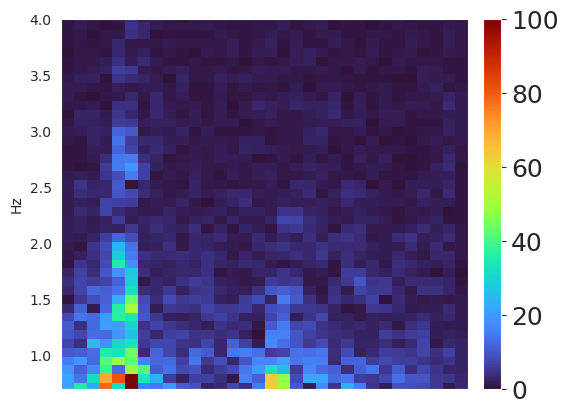

In [61]:
ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data[1304, :, :, 0], cmap='turbo', y_axis='linear', sr=20, vmin=0, vmax=100)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
plt.ylim(0.7, 4)

ax1.set(ylabel=None)
plt.show()

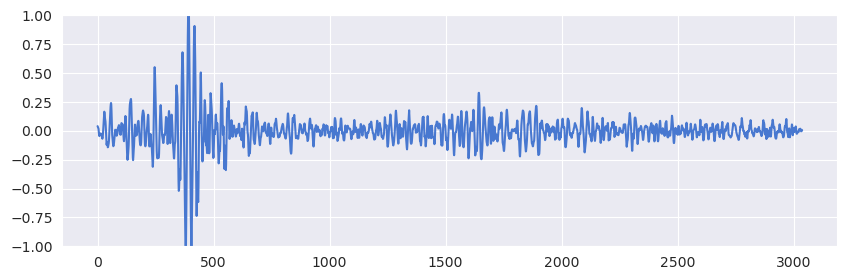

In [59]:
import matplotlib.pyplot as plt
import librosa

n_fft = 254
hop_length = 98

# Perform ISTFT
signal = librosa.istft(data[1304, :, :, 0], hop_length=hop_length, win_length=n_fft)

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 3))  # You can adjust the width and height as needed

ax.plot(signal)
ax.set_ylim(-1, 1)  # Set the y-axis limits to -1 and 1
plt.show()


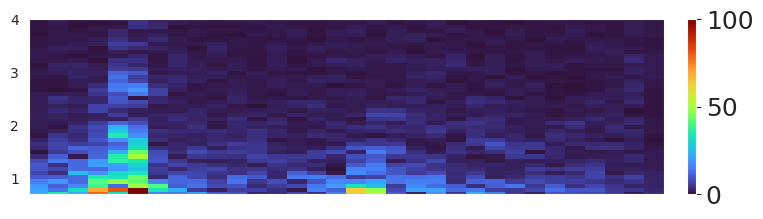

In [60]:
import matplotlib.pyplot as plt
import librosa.display

# Define your spec and ax1

# Set the figure size
fig = plt.figure(figsize=(10, 5))  # You can adjust the width and height as needed

ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(data[1304, :, :, 0], cmap='turbo', y_axis='linear', sr=20, vmin=0, vmax=100)
cbar = plt.colorbar(pad=0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
plt.ylim(0.7, 4)

ax1.set(ylabel=None)
plt.show()


In [62]:
# Second subplot for the waveform (time-domain signal)
ax2 = fig.add_subplot(spec[1, 0])
# Inverse STFT to obtain the time-domain signal
# Replace 'data[120, :, :, 0]' with the appropriate slice of your actual data variable.
signal = librosa.istft(data[1304, :, :, 0], hop_length=hop_length, win_length=n_fft)
ax2.plot(signal, color='blue')
ax2.set_xlabel('Time (samples)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Waveform')
plt.show()

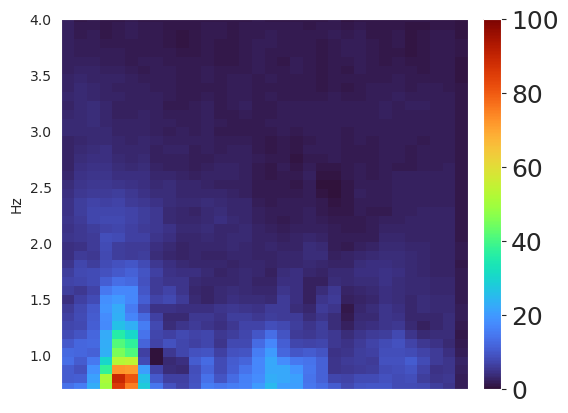

In [63]:
ax1 = fig.add_subplot(spec[0, 0])

librosa.display.specshow(decoded_imgs[1304, :, :, 0], cmap='turbo', y_axis='linear', sr=20, vmin=0, vmax=100)
cbar= plt.colorbar(pad= 0.03)
cbar.ax.tick_params(labelsize=18, rotation=0)
plt.ylim(0.7, 4)
ax1.set(ylabel=None)
plt.show()

# Dataset Creation for Predictive Maintanance

In [20]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler

# Load data
data = np.load('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/Train_Test_Scipy.npy')
datetime_index = np.load('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Preprocessed/train_test_datetime.npy', allow_pickle=True)
clustering_results = np.loadtxt('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/Km-n3-ft_Rewritten.txt', dtype=str)

# Load the autoencoder model
autoencoder = load_model('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/Models/autoencoder-model2')

# Function to get all layer outputs
get_all_layer_outputs = K.function([autoencoder.layers[0].input], [l.output for l in autoencoder.layers[1:]])

# Get the encoded layer output (assuming it's the output of 'dense_1')
layer_output = get_all_layer_outputs([data])
encoded_features = layer_output[5]  # Adjust index 5 to match the 'dense_1' layer in your model

# Apply MinMax scaling to the encoded features
scaler = MinMaxScaler()
scaled_encoded_features = scaler.fit_transform(encoded_features)

# Convert datetime array to pandas datetime and round up to the nearest minute
datetime_index = pd.to_datetime(datetime_index).ceil('min')

# Create DataFrame for scaled encoded features with 'enc_' prefix
scaled_encoded_features_df = pd.DataFrame(scaled_encoded_features)
scaled_encoded_features_df.columns = ['enc_' + str(col) for col in scaled_encoded_features_df.columns]

# Add cluster labels to the DataFrame
clustering_labels_df = pd.DataFrame({'cluster': clustering_results})

# Combine scaled encoded features and cluster labels
combined_df = pd.concat([scaled_encoded_features_df, clustering_labels_df], axis=1)

# Set the rounded datetime as the DataFrame index and name it 'timestamp'
combined_df.index = datetime_index
combined_df.index.name = 'timestamp'

combined_df.head()


,enc_0,enc_1,enc_2,enc_3,enc_4,enc_5,enc_6,enc_7,enc_8,enc_9,...,enc_15,enc_16,enc_17,enc_18,enc_19,enc_20,enc_21,enc_22,enc_23,cluster
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-06-24 22:50:00+00:00,0.0,0.153880,0.131726,0.020461,0.042775,0.0,0.000225,0.0,0.103674,0.0,...,0.0,0.031588,0.097323,2.227753e-02,0.0,0.0,0.014235,0.209731,0.013914,1
2018-06-25 20:31:00+00:00,0.0,0.142621,0.073355,0.028357,0.051817,0.0,0.028261,0.0,0.065544,0.0,...,0.0,0.093951,0.063795,3.866509e-03,0.0,0.0,0.001169,0.178872,0.047715,2
2018-06-26 02:51:00+00:00,0.0,0.128460,0.097686,0.023503,0.060460,0.0,0.022133,0.0,0.017686,0.0,...,0.0,0.084417,0.066729,2.910383e-11,0.0,0.0,0.000000,0.173401,0.054453,1
2018-06-26 02:59:00+00:00,0.0,0.093154,0.065859,0.017310,0.042119,0.0,0.012361,0.0,0.033170,0.0,...,0.0,0.032732,0.048599,1.637670e-02,0.0,0.0,0.007294,0.102231,0.016622,1
2018-06-28 22:33:00+00:00,0.0,0.223360,0.212247,0.114154,0.199226,0.0,0.037208,0.0,0.164736,0.0,...,0.0,0.109253,0.182266,1.183589e-04,0.0,0.0,0.021254,0.277943,0.000000,2


In [21]:
combined_df.to_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/DEC_Results/Encoded_Forecasting_Dataset_Normalized.csv', index=True)

In [59]:
import pandas as pd

# Load the dataset
data_cluster = pd.read_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/DEC_Results/Encoded_Forecasting_Dataset_NotNormalized.csv')

# Filter columns that start with "enc_"
enc_features = [col for col in data_cluster.columns if col.startswith('enc_')]
data_enc = data_cluster[['cluster'] + enc_features]

# Group by 'cluster' and calculate min, mean, median, and max for the filtered features
enc_cluster_summary = data_enc.groupby('cluster').agg(['min', 'mean', 'median', 'max'])

# Reformatting the DataFrame for the desired structure
# Swap levels and sort columns to make clusters as primary column headers
enc_cluster_summary_adjusted = enc_cluster_summary.stack(level=0).unstack(level=0).swaplevel(axis=1).sort_index(axis=1)

# Display the first few rows of the adjusted summary
enc_cluster_summary_adjusted.head()

cluster            0                                       1              \
                 max        mean      median  min        max        mean   
enc_0      -0.998544   -0.999998   -1.000000 -1.0    -1.0000   -1.000000   
enc_1     871.231450  147.304620  130.282175 -1.0  1080.1642  287.277070   
enc_10   1047.830600  189.216231  171.658815 -1.0  1713.9205  369.045156   
enc_11     -1.000000   -1.000000   -1.000000 -1.0    -1.0000   -1.000000   
enc_12     -1.000000   -1.000000   -1.000000 -1.0    -1.0000   -1.000000   

cluster                          2                              
            median  min        max        mean     median  min  
enc_0     -1.00000 -1.0    -1.0000   -1.000000   -1.00000 -1.0  
enc_1    268.14914 -1.0  2091.1790  523.670707  476.24708 -1.0  
enc_10   345.77850 -1.0  3922.6042  831.440185  730.12902 -1.0  
enc_11    -1.00000 -1.0    -1.0000   -1.000000   -1.00000 -1.0  
enc_12    -1.00000 -1.0    -1.0000   -1.000000   -1.00000 -1.0

In [60]:
enc_cluster_summary_adjusted.to_csv('/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/DEC_Results/Summary.csv', index=True)

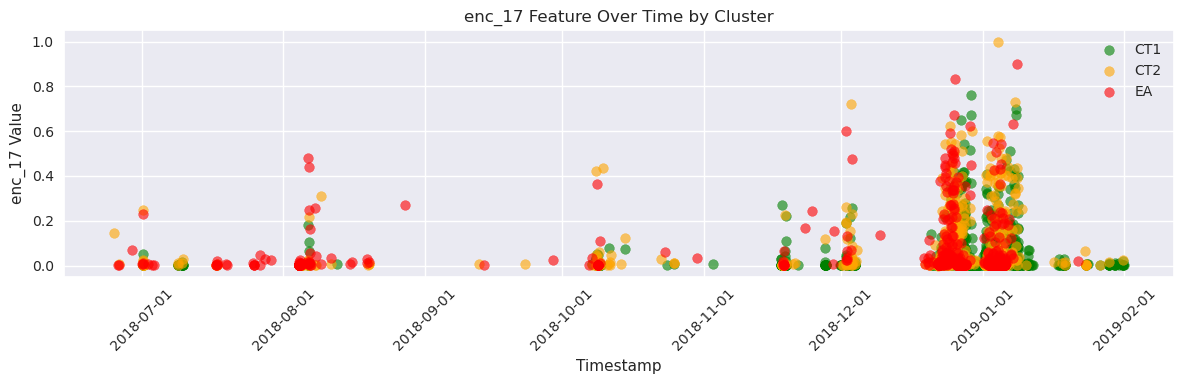

In [84]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot enc_17 over time with colors based on cluster labels
plt.figure(figsize=(12, 4))

# Plot each cluster with its respective color
colors = {0: 'green', 1: 'orange', 2: 'red'}
labels = {0: 'CT1', 1: 'CT2', 2: 'EA'}

for cluster in colors:
    # Filter data for each cluster
    cluster_data = combined_df[combined_df['cluster'] == str(cluster)]
    # Use the index directly for plotting
    plt.scatter(cluster_data.index, cluster_data['enc_4'], color=colors[cluster], label=labels[cluster], alpha=0.6)

plt.xlabel('Timestamp')
plt.ylabel('enc_17 Value')  # Make sure this matches the correct column name in your DataFrame
plt.title('enc_17 Feature Over Time by Cluster')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.tight_layout()
plt.show()


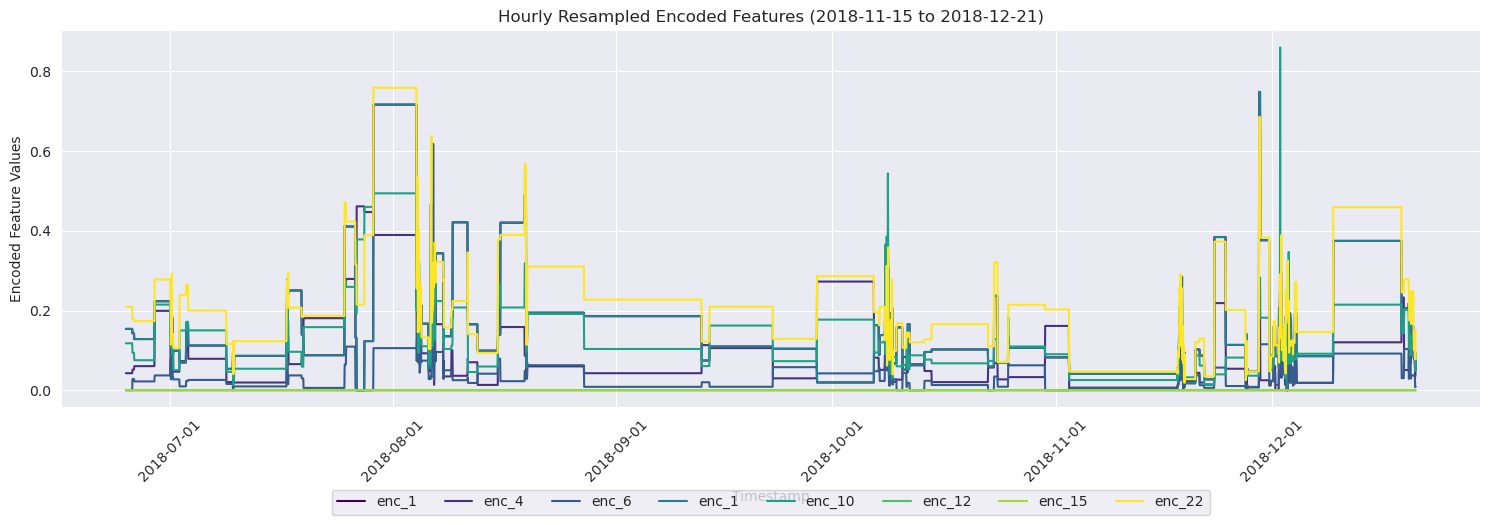

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

# Load the dataset
file_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/DEC_Results/Encoded_Forecasting_Dataset_Normalized.csv'
data = pd.read_csv(file_path)

# Convert the 'timestamp' column to datetime and set it as the index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Filter data between 2018-06-24 and 2018-12-21
mask = (data.index >= '2018-06-24') & (data.index <= '2018-12-21')
filtered_data = data.loc[mask]

# Resample the filtered data to an hourly frequency, taking the mean of the features
filtered_data_hourly = filtered_data.resample('1H').max()

# Forward fill any missing values after resampling
filtered_data_hourly_ffill = filtered_data_hourly.ffill()

# Specify the features you want to plot. If empty, all features will be plotted.
# Example: features_to_plot = ['feature1', 'feature2']
features_to_plot = ['enc_1','enc_4','enc_6', 'enc_1','enc_10','enc_12','enc_15','enc_22']  # Put feature names as strings in this list

# If no specific features are provided, plot all features
if not features_to_plot:
    features_to_plot = filtered_data.columns

# Plot specified features on a single time series plot with different colors
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

# Create a color cycle iterator
colors = plt.cm.viridis(np.linspace(0, 1, len(features_to_plot)))

# Plot each specified feature
for i, column in enumerate(features_to_plot):
    plt.plot(filtered_data_hourly_ffill.index, filtered_data_hourly_ffill[column], label=column, color=colors[i])

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# Include other plot elements
plt.title('Hourly Resampled Encoded Features (2018-11-15 to 2018-12-21)')
plt.xlabel('Timestamp')
plt.ylabel('Encoded Feature Values')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/tmp/ipykernel_2113548/4202501608.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts = filtered_data.groupby(['cluster', pd.Grouper(freq='7D')]).size().unstack(level=0, fill_value=0)


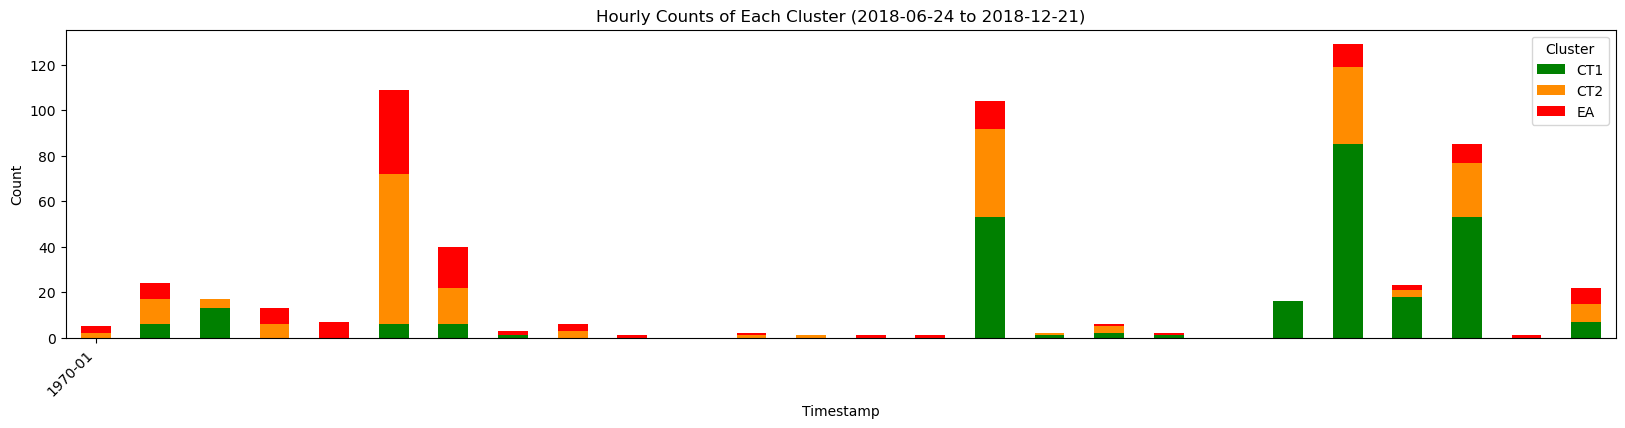

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the dataset
file_path = '/run/media/viblab/Markov2/Haykal/AnakKrakatauEWSFinal/data/DEC_Results/Encoded_Forecasting_Dataset.csv'
data = pd.read_csv(file_path)

# Ensure the 'cluster' column is read as a category if it's not already.
data['cluster'] = data['cluster'].astype('category')

# Convert the 'timestamp' column to datetime and set it as the index
data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True)
data.set_index('timestamp', inplace=True)


# Filter data between 2018-06-24 and 2018-12-21
start_date = '2018-06-24'
end_date = '2018-12-21'
mask = (data.index >= start_date) & (data.index <= end_date)
filtered_data = data.loc[mask]

# Group by 'cluster' and 'timestamp' and count occurrences within each hour
cluster_counts = filtered_data.groupby(['cluster', pd.Grouper(freq='7D')]).size().unstack(level=0, fill_value=0)

# Define the color mapping and cluster names
colors = ['green', 'darkorange', 'red']
cluster_names = ['CT1', 'CT2', 'EA']

# Plot the hourly counts of each cluster
plt.figure(figsize=(20, 4))
cluster_counts.plot(kind='bar', stacked=True, color=colors, ax=plt.gca())

# Rename legend labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, cluster_names, title='Cluster')

# Set major ticks to monthly frequency
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate and align the tick labels so they look better
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right")

# Set plot title and labels
plt.title('Hourly Counts of Each Cluster (2018-06-24 to 2018-12-21)')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Show plot
plt.show()
